# Setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import random
import scipy
import gc
import joblib
import rtdl

from tqdm import tqdm
from typing import Any, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def conf_matrix(y_true, y_pred):    
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    mat = confusion_matrix(y_true, y_pred)
    labels = ['0(Non Risk)', '1(Risk)']
    colors=['whitesmoke', 'steelblue']
    sns.heatmap(mat, annot=True, cmap=colors, xticklabels=labels, yticklabels=labels, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print('Accuracy:', acc)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1:', f1)

In [3]:
def seed_everything(seed = 21):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Data Import

In [4]:
data = pd.read_csv('./DA_data_mean.csv', index_col=0)
print(data.shape)
data.head()

(69185, 2921)


,hadm_id,intime,gender,anchor_age,mortality_in_second,mortality_in_3days,Anderson (gastric),Blakemore,Cath Lab,Cerebral Subdural #1,...,Vti High,WBC_y,WBCApacheIIValue,WBCScore_ApacheIV,WBC_ApacheIV,Warming Device,Warming Device Status,WbcApacheIIScore,Yawning,Yawning (COWS)
0,24528534,2154-03-03 04:11:00,M,25,NaN,False,NaN,NaN,NaN,NaN,...,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28960964,2150-06-19 17:57:00,M,42,NaN,False,NaN,NaN,NaN,NaN,...,916.666667,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27385897,2138-02-05 18:54:00,M,70,835560.0,False,NaN,NaN,NaN,NaN,...,900.000000,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23483021,2123-10-25 10:35:00,M,87,NaN,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20817525,2200-07-12 00:33:00,M,72,NaN,False,NaN,NaN,NaN,NaN,...,NaN,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.gender = data.gender.replace({'M':1, 'F':0})
y = data.mortality_in_3days.replace({True:1, False:0})

X = data.drop(['hadm_id', 'intime', 'mortality_in_second', 'mortality_in_3days'], axis=1)
X.fillna(0, inplace=True)

del data
gc.collect()

0

In [6]:
y.value_counts()

mortality_in_3days
0    66120
1     3065
Name: count, dtype: int64

In [7]:
# SHAP(XGBoost) based feature importance 
shap_fi = pd.read_csv('./shap_fi_mean.csv', index_col=0)
shap_fi

,column_name,shap_importance
1,anchor_age,0.411092
1923,Lactic Acid,0.331595
2750,Temperature Fahrenheit,0.266724
2050,O2 saturation pulseoxymetry,0.264046
1095,Braden Mobility,0.227278
...,...,...
1155,CT #2 Crepitus,0.000000
1156,CT #2 Drainage,0.000000
1157,CT #2 Dressing,0.000000
1158,CT #2 Fluctuate,0.000000


In [8]:
shap_fi[shap_fi.shap_importance > 0].shape

(514, 2)

In [9]:
# non-zero Shapley value -> 514 features
X = X[shap_fi.iloc[:514, :].column_name.values]

X, y = shuffle(X, y, random_state=21)

X_normal = X[y==0]
X_abnormal = X[y==1]
y_normal = y[y==0]
y_abnormal = y[y==1]

In [10]:
X_train_normal = X_normal.iloc[:60000, :]
X_train_abnormal = X_abnormal.iloc[:2000, :]

X_test_normal = X_normal.iloc[60000:, :]
X_test_abnormal = X_abnormal.iloc[2000:, :]

y_train_normal = y_normal[:60000]
y_train_abnormal = y_abnormal[:2000]

y_test_normal = y_normal[60000:]
y_test_abnormal = y_abnormal[2000:]

X_train_all = pd.concat([X_train_normal, X_train_abnormal])
X_test = pd.concat([X_test_normal, X_test_abnormal])

y_train_all = pd.concat([y_train_normal, y_train_abnormal])
y_test = pd.concat([y_test_normal, y_test_abnormal])

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, stratify=y_train_all, test_size=0.1, random_state=21)

X_train.shape, X_val.shape, X_test.shape, X_train_all.shape 

((55800, 514), (6200, 514), (7185, 514), (62000, 514))

In [11]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts(), y_train_all.value_counts()

(mortality_in_3days
 0    54000
 1     1800
 Name: count, dtype: int64,
 mortality_in_3days
 0    6000
 1     200
 Name: count, dtype: int64,
 mortality_in_3days
 0    6120
 1    1065
 Name: count, dtype: int64,
 mortality_in_3days
 0    60000
 1     2000
 Name: count, dtype: int64)

In [12]:
ss = StandardScaler()
X_train.iloc[:, :] = ss.fit_transform(X_train)
X_val.iloc[:, :] = ss.transform(X_val)
X_test.iloc[:, :] = ss.transform(X_test)

ss = StandardScaler()
X_train_all.iloc[:, :] = ss.fit_transform(X_train_all)

# X_train.to_csv('train.csv')
# X_val.to_csv('val.csv')
X_test.to_csv('test.csv')
y_test.to_csv('y_test.csv')

In [13]:
# upsample -> abnormal(dies in 3 days) case 
X_train_normal = X_train[y_train==0]
X_train_abnormal = X_train[y_train==1]

y_train_normal = y_train[y_train==0]
y_train_abnormal = y_train[y_train==1]
    
X_abnormal_res, y_abnormal_res = resample(X_train_abnormal, y_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=21)
X_train = pd.concat([X_train_normal, X_abnormal_res])
y_train = pd.concat([y_train_normal, y_abnormal_res])
    
# shuffle 
X_res, y_res = shuffle(X_train, y_train, random_state=21)
X_res.shape

(108000, 514)

In [14]:
# upsample -> abnormal(dies in 3 days) case 
X_train_normal = X_train_all[y_train_all==0]
X_train_abnormal = X_train_all[y_train_all==1]

y_train_normal = y_train_all[y_train_all==0]
y_train_abnormal = y_train_all[y_train_all==1]
    
X_abnormal_res, y_abnormal_res = resample(X_train_abnormal, y_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=21)
X_train_all = pd.concat([X_train_normal, X_abnormal_res])
y_train_all = pd.concat([y_train_normal, y_abnormal_res])
    
# shuffle 
X_res_all, y_res_all = shuffle(X_train_all, y_train_all, random_state=21)

# X_res_all : no validation subset 
X_res_all.shape 

(120000, 514)

# TabNet

Decide not to use TabNet ...

In [44]:
sparse_X_train = scipy.sparse.csr_matrix(X_res)  
sparse_X_valid = scipy.sparse.csr_matrix(X_val) 

In [45]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(optimizer_fn=torch.optim.Adam,
                                      verbose=5,)

unsupervised_model.fit(X_train=X_res.values,
                       eval_set=[X_val.values],
                       max_epochs=50,
                       patience=10,
                       batch_size=1024,
                       virtual_batch_size=256,
                       num_workers=0,
                       drop_last=False,
                       pretraining_ratio=0.5,)

epoch 0  | loss: 9788582.16798| val_0_unsup_loss_numpy: 1508.30517578125|  0:00:25s
epoch 5  | loss: 4085.23881| val_0_unsup_loss_numpy: 23.104700088500977|  0:02:08s
epoch 10 | loss: 193.11348| val_0_unsup_loss_numpy: 2.970360040664673|  0:03:34s
epoch 15 | loss: 70.86699| val_0_unsup_loss_numpy: 4.211780071258545|  0:04:59s
epoch 20 | loss: 101.00015| val_0_unsup_loss_numpy: 1.0170199871063232|  0:06:25s
epoch 25 | loss: 32.75263| val_0_unsup_loss_numpy: 1.0509999990463257|  0:07:55s
epoch 30 | loss: 13.6784 | val_0_unsup_loss_numpy: 1.1903799772262573|  0:09:14s

Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_unsup_loss_numpy = 1.0152900218963623


In [46]:
tabnet_params = {"optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=1e-3, weight_decay=1e-2),
                 "scheduler_fn": torch.optim.lr_scheduler.StepLR,
                 "scheduler_params":{"step_size":10, "gamma":0.99},
                 "mask_type": 'sparsemax',
                 "device_name": 'cpu',
                 "n_d": 8,
                 "n_a": 8,
                 "n_steps": 3,
                 "gamma": 1.3,
                 "seed": 21}

tabnet = TabNetClassifier(**tabnet_params)

max_epochs = 150

# Fitting the model
tabnet.fit(X_train=sparse_X_train, y_train=y_res,
           eval_set=[(sparse_X_train, y_res), (sparse_X_valid, y_val)],
           eval_name=['train', 'val'],
           eval_metric=['accuracy', 'logloss'],
           max_epochs=max_epochs,
           patience=50,
           batch_size=1024,
           virtual_batch_size=256,
           from_unsupervised=unsupervised_model)

epoch 0  | loss: 0.96655 | train_accuracy: 0.53551 | train_logloss: 0.70659 | val_accuracy: 0.18984 | val_logloss: 0.76577 |  0:00:41s
epoch 1  | loss: 0.7065  | train_accuracy: 0.52465 | train_logloss: 0.6906  | val_accuracy: 0.17839 | val_logloss: 0.7756  |  0:01:21s
epoch 2  | loss: 0.67875 | train_accuracy: 0.60585 | train_logloss: 0.67211 | val_accuracy: 0.37016 | val_logloss: 0.75845 |  0:02:02s
epoch 3  | loss: 0.66018 | train_accuracy: 0.62605 | train_logloss: 0.65606 | val_accuracy: 0.41516 | val_logloss: 0.743   |  0:02:44s
epoch 4  | loss: 0.64154 | train_accuracy: 0.6405  | train_logloss: 0.63722 | val_accuracy: 0.44935 | val_logloss: 0.71197 |  0:03:23s
epoch 5  | loss: 0.61956 | train_accuracy: 0.65806 | train_logloss: 0.6192  | val_accuracy: 0.44355 | val_logloss: 0.72731 |  0:04:02s
epoch 6  | loss: 0.59432 | train_accuracy: 0.68304 | train_logloss: 0.59419 | val_accuracy: 0.49226 | val_logloss: 0.66147 |  0:04:42s
epoch 7  | loss: 0.56406 | train_accuracy: 0.71194 | tr

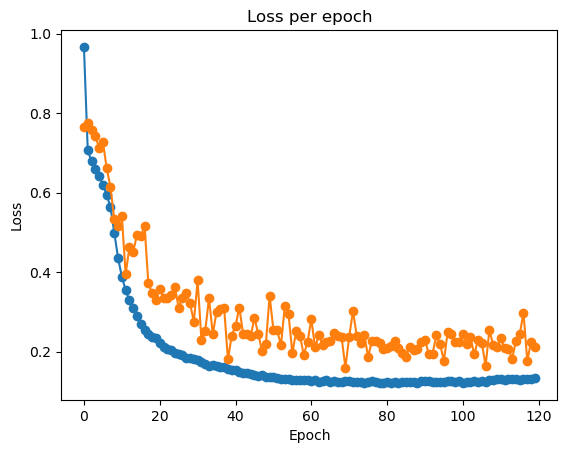

In [47]:
# plot loss
plt.plot(tabnet.history['loss'], marker='o', label='train')
plt.plot(tabnet.history['val_logloss'], marker='o', label='val')
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

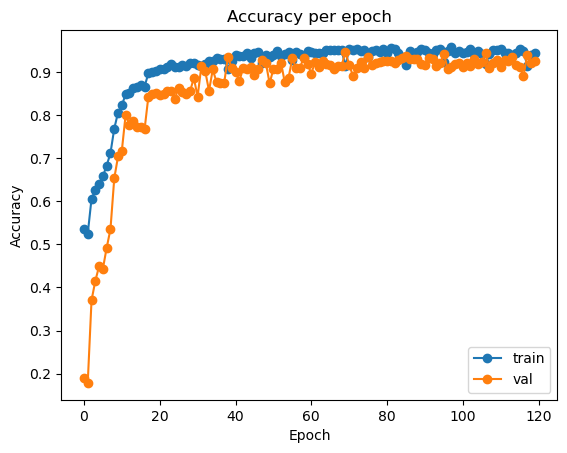

In [48]:
# plot accuracy
plt.plot(tabnet.history['train_accuracy'], label='train', marker='o')
plt.plot(tabnet.history['val_accuracy'], label='val', marker='o')
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

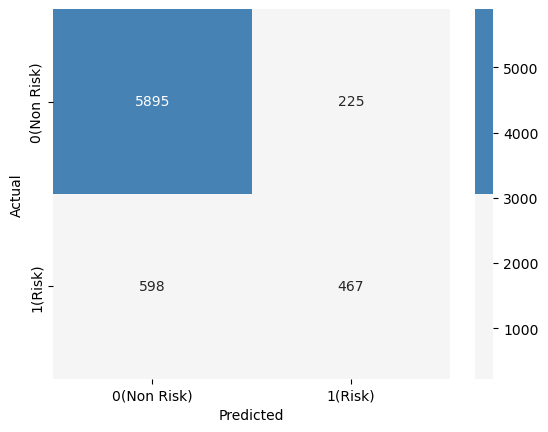

Accuracy: 0.885455810716771
Recall: 0.4384976525821596
Precision: 0.6748554913294798
F1: 0.5315879339783722


In [49]:
preds = tabnet.predict(X_test.values)

conf_matrix(y_test, preds)

In [50]:
# save model
saved_filepath = tabnet.save_model('TabNet')

Successfully saved model at TabNet.zip


# XGBoost

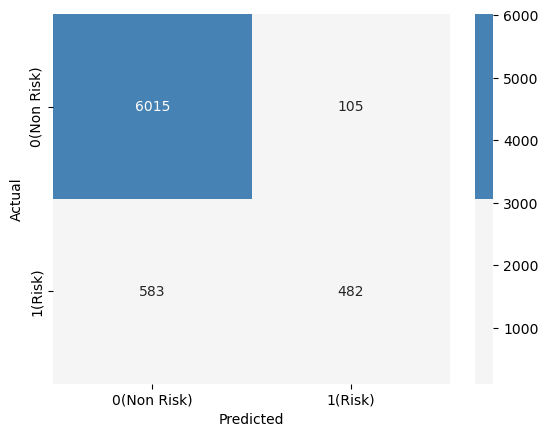

Accuracy: 0.9042449547668754
Recall: 0.45258215962441317
Precision: 0.8211243611584327
F1: 0.5835351089588378


In [15]:
xgb = XGBClassifier(seed=21)
xgb.fit(X_res_all.values, y_res_all)

preds = xgb.predict(X_test.values)
conf_matrix(y_test, preds)

In [16]:
joblib.dump(xgb, 'XGBoost.pkl')

['XGBoost.pkl']

# LightGBM

[LightGBM] [Info] Number of positive: 60000, number of negative: 60000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59968
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 514
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


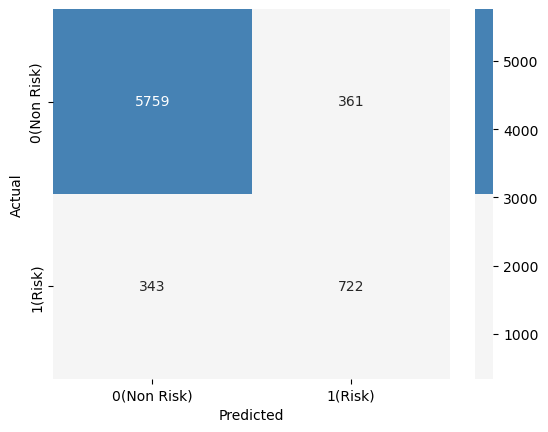

Accuracy: 0.9020180932498261
Recall: 0.6779342723004694
Precision: 0.6666666666666666
F1: 0.6722532588454375


In [53]:
lgbm = LGBMClassifier(seed=21)
lgbm.fit(X_res_all.values, y_res_all)

preds = lgbm.predict(X_test.values)
conf_matrix(y_test, preds)

In [54]:
# save model
joblib.dump(lgbm, 'LightGBM.pkl')

['LightGBM.pkl']

# RandomForest

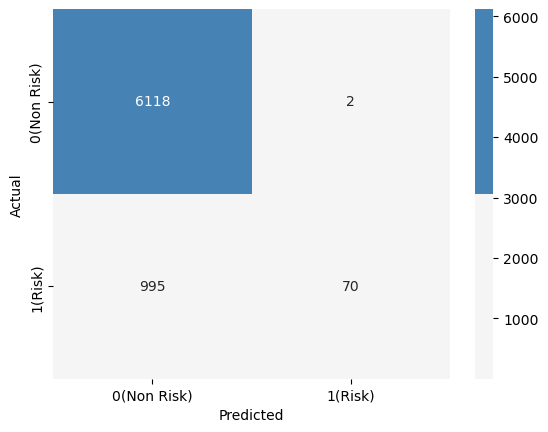

Accuracy: 0.8612386917188587
Recall: 0.06572769953051644
Precision: 0.9722222222222222
F1: 0.12313104661389623


In [55]:
rf = RandomForestClassifier(n_estimators=300, random_state=21)
rf.fit(X_res_all.values, y_res_all)

preds = rf.predict(X_test.values)
conf_matrix(y_test, preds)

In [56]:
# save model
joblib.dump(rf, 'RandomForest.pkl')

['RandomForest.pkl']

# Logistic Regression

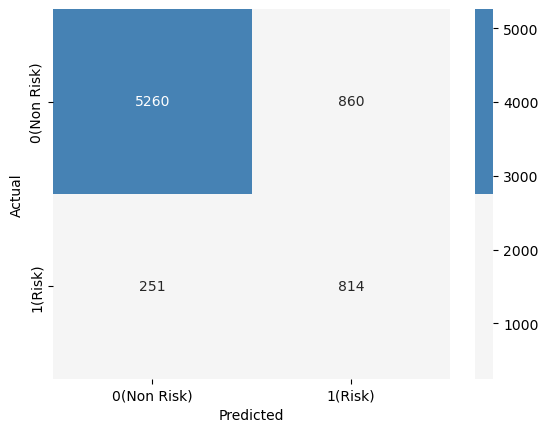

Accuracy: 0.8453723034098817
Recall: 0.7643192488262911
Precision: 0.4862604540023895
F1: 0.5943775100401606


In [57]:
lr = LogisticRegression(C=0.01, random_state=21)
lr.fit(X_res_all.values, y_res_all)

preds = lr.predict(X_test.values)
conf_matrix(y_test, preds)

In [58]:
# save model
joblib.dump(lr, 'LogisticRegression.pkl')

['LogisticRegression.pkl']

# ResNet

In [59]:
def model_train(model, data_loader, criterion, optimizer, device, history, scheduler=None):
    model.train()
    running_loss = 0
    corr = 0

    # for rtdl
    for data, label in tqdm(data_loader):
        optimizer.zero_grad()

        data, label = data.to(device), label.to(device)
        output = model(data)
        output = torch.sigmoid(output)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        pred = output >= torch.FloatTensor([0.5]).to(device)
        corr += pred.eq(label).sum().item()
        running_loss += loss.item() * data.size(0)

    if scheduler:
        scheduler.step()

    # Average accuracy & loss
    accuracy = corr / len(data_loader.dataset)
    loss = running_loss / len(data_loader.dataset)
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)

    return loss, accuracy, history

def model_evaluate(model, data_loader, criterion, device, history):
    model.eval()
    with torch.no_grad():
        running_loss = 0
        corr = 0

        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            output = torch.sigmoid(output)

            pred = output >= torch.FloatTensor([0.5]).to(device)
            corr += pred.eq(label).sum().item()
            running_loss += criterion(output, label).item() * data.size(0)

        accuracy = corr / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        history['val_loss'].append(loss)
        history['val_accuracy'].append(accuracy)

        return loss, accuracy, history
    
def plot_loss(history):
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

def plot_acc(history):
    plt.plot(history['train_accuracy'], label='train', marker='o')
    plt.plot(history['val_accuracy'], label='val',  marker='o')
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

In [60]:
resnet = rtdl.ResNet.make_baseline(d_in=X_res.shape[1],
                                   d_main=256,
                                   d_hidden=128,
                                   dropout_first=0.3,
                                   dropout_second=0.3,
                                   n_blocks=2,
                                   d_out=1)

In [61]:
class TensorData(Dataset):
    def __init__(self, data, label):
        self.data = data 
        self.label = label
        self.len = self.label.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return self.len

In [62]:
train_dataset = TensorData(torch.tensor(X_res.values, dtype=torch.float), torch.tensor(y_res.values.reshape(-1, 1), dtype=torch.float))
val_dataset = TensorData(torch.tensor(X_val.values, dtype=torch.float), torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float))
test_dataset = TensorData(torch.tensor(X_test.values, dtype=torch.float), torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [63]:
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet.parameters(), lr = 1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}

device = 'cpu'
EPOCHS = 150
max_loss = np.inf

for epoch in range(EPOCHS):
    train_loss, train_acc, history = model_train(resnet, train_loader, criterion, optimizer, device, history, scheduler)
    val_loss, val_acc, history = model_evaluate(resnet, val_loader, criterion, device, history)

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(resnet.state_dict(), 'ResNet_Best.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|██████████| 106/106 [00:03<00:00, 30.76it/s]


[INFO] val_loss has been improved from inf to 0.21579. Save model.
epoch 01, loss: 0.30881, accuracy: 0.87044, val_loss: 0.21579, val_accuracy: 0.91677 



100%|██████████| 106/106 [00:03<00:00, 31.41it/s]


[INFO] val_loss has been improved from 0.21579 to 0.19443. Save model.
epoch 02, loss: 0.15882, accuracy: 0.95169, val_loss: 0.19443, val_accuracy: 0.93097 



100%|██████████| 106/106 [00:03<00:00, 33.24it/s]


epoch 03, loss: 0.12228, accuracy: 0.96681, val_loss: 0.21071, val_accuracy: 0.92419 



100%|██████████| 106/106 [00:03<00:00, 30.84it/s]


[INFO] val_loss has been improved from 0.19443 to 0.19081. Save model.
epoch 04, loss: 0.11067, accuracy: 0.97220, val_loss: 0.19081, val_accuracy: 0.93452 



100%|██████████| 106/106 [00:03<00:00, 30.36it/s]


[INFO] val_loss has been improved from 0.19081 to 0.17612. Save model.
epoch 05, loss: 0.10623, accuracy: 0.97490, val_loss: 0.17612, val_accuracy: 0.94113 



100%|██████████| 106/106 [00:03<00:00, 32.70it/s]


epoch 06, loss: 0.11051, accuracy: 0.97316, val_loss: 0.17697, val_accuracy: 0.94145 



100%|██████████| 106/106 [00:03<00:00, 31.04it/s]


epoch 07, loss: 0.11206, accuracy: 0.97271, val_loss: 0.20147, val_accuracy: 0.92726 



100%|██████████| 106/106 [00:03<00:00, 32.49it/s]


epoch 08, loss: 0.12218, accuracy: 0.96876, val_loss: 0.18983, val_accuracy: 0.92887 



100%|██████████| 106/106 [00:03<00:00, 31.90it/s]


epoch 09, loss: 0.12604, accuracy: 0.96721, val_loss: 0.19851, val_accuracy: 0.92806 



100%|██████████| 106/106 [00:03<00:00, 31.76it/s]


epoch 10, loss: 0.13467, accuracy: 0.96453, val_loss: 0.20213, val_accuracy: 0.92629 



100%|██████████| 106/106 [00:03<00:00, 32.09it/s]


epoch 11, loss: 0.14231, accuracy: 0.96096, val_loss: 0.19767, val_accuracy: 0.92968 



100%|██████████| 106/106 [00:03<00:00, 32.41it/s]


epoch 12, loss: 0.14826, accuracy: 0.95748, val_loss: 0.21684, val_accuracy: 0.91855 



100%|██████████| 106/106 [00:03<00:00, 30.31it/s]


epoch 13, loss: 0.15442, accuracy: 0.95384, val_loss: 0.20595, val_accuracy: 0.92726 



100%|██████████| 106/106 [00:03<00:00, 31.28it/s]


epoch 14, loss: 0.16075, accuracy: 0.95189, val_loss: 0.22289, val_accuracy: 0.91242 



100%|██████████| 106/106 [00:03<00:00, 31.72it/s]


epoch 15, loss: 0.16426, accuracy: 0.95106, val_loss: 0.20797, val_accuracy: 0.92516 



100%|██████████| 106/106 [00:03<00:00, 32.25it/s]


epoch 16, loss: 0.16418, accuracy: 0.94984, val_loss: 0.21052, val_accuracy: 0.92129 



100%|██████████| 106/106 [00:03<00:00, 30.44it/s]


epoch 17, loss: 0.16693, accuracy: 0.94831, val_loss: 0.22775, val_accuracy: 0.91226 



100%|██████████| 106/106 [00:03<00:00, 31.59it/s]


epoch 18, loss: 0.16947, accuracy: 0.94713, val_loss: 0.21533, val_accuracy: 0.92210 



100%|██████████| 106/106 [00:03<00:00, 30.34it/s]


epoch 19, loss: 0.16355, accuracy: 0.94901, val_loss: 0.22760, val_accuracy: 0.91242 



100%|██████████| 106/106 [00:03<00:00, 31.38it/s]


epoch 20, loss: 0.16393, accuracy: 0.94888, val_loss: 0.20514, val_accuracy: 0.92048 



100%|██████████| 106/106 [00:03<00:00, 32.48it/s]


epoch 21, loss: 0.16420, accuracy: 0.94834, val_loss: 0.20575, val_accuracy: 0.92323 



100%|██████████| 106/106 [00:03<00:00, 31.47it/s]


epoch 22, loss: 0.16196, accuracy: 0.94865, val_loss: 0.21170, val_accuracy: 0.92129 



100%|██████████| 106/106 [00:03<00:00, 32.39it/s]


epoch 23, loss: 0.15950, accuracy: 0.94908, val_loss: 0.22779, val_accuracy: 0.91581 



100%|██████████| 106/106 [00:03<00:00, 32.03it/s]


epoch 24, loss: 0.15687, accuracy: 0.95035, val_loss: 0.19747, val_accuracy: 0.92565 



100%|██████████| 106/106 [00:03<00:00, 32.30it/s]


epoch 25, loss: 0.15420, accuracy: 0.95118, val_loss: 0.21179, val_accuracy: 0.91903 



100%|██████████| 106/106 [00:03<00:00, 31.60it/s]


epoch 26, loss: 0.15526, accuracy: 0.95047, val_loss: 0.19444, val_accuracy: 0.92984 



100%|██████████| 106/106 [00:03<00:00, 33.16it/s]


epoch 27, loss: 0.15105, accuracy: 0.95185, val_loss: 0.19802, val_accuracy: 0.92984 



100%|██████████| 106/106 [00:03<00:00, 31.58it/s]


epoch 28, loss: 0.15014, accuracy: 0.95249, val_loss: 0.21227, val_accuracy: 0.92129 



100%|██████████| 106/106 [00:03<00:00, 33.02it/s]


epoch 29, loss: 0.14564, accuracy: 0.95433, val_loss: 0.19939, val_accuracy: 0.92839 



100%|██████████| 106/106 [00:03<00:00, 32.21it/s]


epoch 30, loss: 0.14502, accuracy: 0.95408, val_loss: 0.21443, val_accuracy: 0.92194 



100%|██████████| 106/106 [00:03<00:00, 31.20it/s]


epoch 31, loss: 0.14323, accuracy: 0.95485, val_loss: 0.20336, val_accuracy: 0.92984 



100%|██████████| 106/106 [00:03<00:00, 32.75it/s]


epoch 32, loss: 0.13992, accuracy: 0.95606, val_loss: 0.17765, val_accuracy: 0.93435 



100%|██████████| 106/106 [00:03<00:00, 32.51it/s]


epoch 33, loss: 0.13788, accuracy: 0.95706, val_loss: 0.19252, val_accuracy: 0.93645 



100%|██████████| 106/106 [00:03<00:00, 32.18it/s]


[INFO] val_loss has been improved from 0.17612 to 0.17053. Save model.
epoch 34, loss: 0.13788, accuracy: 0.95741, val_loss: 0.17053, val_accuracy: 0.94145 



100%|██████████| 106/106 [00:03<00:00, 32.33it/s]


epoch 35, loss: 0.13784, accuracy: 0.95810, val_loss: 0.20255, val_accuracy: 0.92516 



100%|██████████| 106/106 [00:03<00:00, 32.21it/s]


[INFO] val_loss has been improved from 0.17053 to 0.16724. Save model.
epoch 36, loss: 0.13211, accuracy: 0.96025, val_loss: 0.16724, val_accuracy: 0.93919 



100%|██████████| 106/106 [00:03<00:00, 31.75it/s]


[INFO] val_loss has been improved from 0.16724 to 0.15997. Save model.
epoch 37, loss: 0.13163, accuracy: 0.95945, val_loss: 0.15997, val_accuracy: 0.94468 



100%|██████████| 106/106 [00:03<00:00, 33.18it/s]


epoch 38, loss: 0.12844, accuracy: 0.96103, val_loss: 0.17852, val_accuracy: 0.93774 



100%|██████████| 106/106 [00:03<00:00, 31.15it/s]


epoch 39, loss: 0.12863, accuracy: 0.96108, val_loss: 0.21509, val_accuracy: 0.92774 



100%|██████████| 106/106 [00:03<00:00, 32.33it/s]


epoch 40, loss: 0.12442, accuracy: 0.96323, val_loss: 0.16472, val_accuracy: 0.94177 



100%|██████████| 106/106 [00:03<00:00, 31.61it/s]


epoch 41, loss: 0.12569, accuracy: 0.96252, val_loss: 0.16675, val_accuracy: 0.93774 



100%|██████████| 106/106 [00:03<00:00, 30.82it/s]


epoch 42, loss: 0.12784, accuracy: 0.96130, val_loss: 0.17013, val_accuracy: 0.93710 



100%|██████████| 106/106 [00:03<00:00, 29.29it/s]


epoch 43, loss: 0.12305, accuracy: 0.96405, val_loss: 0.18921, val_accuracy: 0.93177 



100%|██████████| 106/106 [00:03<00:00, 31.82it/s]


epoch 44, loss: 0.12091, accuracy: 0.96441, val_loss: 0.21692, val_accuracy: 0.91694 



100%|██████████| 106/106 [00:03<00:00, 30.96it/s]


epoch 45, loss: 0.11998, accuracy: 0.96567, val_loss: 0.17303, val_accuracy: 0.93726 



100%|██████████| 106/106 [00:03<00:00, 30.73it/s]


epoch 46, loss: 0.12171, accuracy: 0.96364, val_loss: 0.16872, val_accuracy: 0.94032 



100%|██████████| 106/106 [00:03<00:00, 30.65it/s]


epoch 47, loss: 0.11853, accuracy: 0.96535, val_loss: 0.18204, val_accuracy: 0.93677 



100%|██████████| 106/106 [00:03<00:00, 30.19it/s]


[INFO] val_loss has been improved from 0.15997 to 0.15611. Save model.
epoch 48, loss: 0.12106, accuracy: 0.96390, val_loss: 0.15611, val_accuracy: 0.94839 



100%|██████████| 106/106 [00:03<00:00, 30.86it/s]


epoch 49, loss: 0.12131, accuracy: 0.96358, val_loss: 0.16924, val_accuracy: 0.93855 



100%|██████████| 106/106 [00:03<00:00, 29.00it/s]


epoch 50, loss: 0.11550, accuracy: 0.96729, val_loss: 0.18791, val_accuracy: 0.93468 



100%|██████████| 106/106 [00:03<00:00, 28.02it/s]


epoch 51, loss: 0.11708, accuracy: 0.96644, val_loss: 0.19864, val_accuracy: 0.92758 



100%|██████████| 106/106 [00:04<00:00, 25.49it/s]


epoch 52, loss: 0.11538, accuracy: 0.96694, val_loss: 0.16625, val_accuracy: 0.94065 



100%|██████████| 106/106 [00:04<00:00, 21.28it/s]


epoch 53, loss: 0.11336, accuracy: 0.96760, val_loss: 0.16874, val_accuracy: 0.94065 



100%|██████████| 106/106 [00:07<00:00, 14.98it/s]


epoch 54, loss: 0.11502, accuracy: 0.96737, val_loss: 0.16689, val_accuracy: 0.94226 



100%|██████████| 106/106 [00:07<00:00, 14.22it/s]


epoch 55, loss: 0.11444, accuracy: 0.96749, val_loss: 0.16350, val_accuracy: 0.94290 



100%|██████████| 106/106 [00:07<00:00, 14.38it/s]


epoch 56, loss: 0.11178, accuracy: 0.96766, val_loss: 0.17946, val_accuracy: 0.93871 



100%|██████████| 106/106 [00:08<00:00, 13.19it/s]


epoch 57, loss: 0.11258, accuracy: 0.96841, val_loss: 0.19174, val_accuracy: 0.93065 



100%|██████████| 106/106 [00:08<00:00, 12.59it/s]


epoch 58, loss: 0.11107, accuracy: 0.96904, val_loss: 0.15880, val_accuracy: 0.94516 



100%|██████████| 106/106 [00:08<00:00, 12.34it/s]


epoch 59, loss: 0.11250, accuracy: 0.96895, val_loss: 0.17859, val_accuracy: 0.93306 



100%|██████████| 106/106 [00:09<00:00, 11.67it/s]


epoch 60, loss: 0.11137, accuracy: 0.96860, val_loss: 0.17992, val_accuracy: 0.93500 



100%|██████████| 106/106 [00:09<00:00, 10.73it/s]


epoch 61, loss: 0.11101, accuracy: 0.96929, val_loss: 0.17793, val_accuracy: 0.93774 



100%|██████████| 106/106 [00:09<00:00, 10.66it/s]


epoch 62, loss: 0.11002, accuracy: 0.96922, val_loss: 0.19539, val_accuracy: 0.92726 



100%|██████████| 106/106 [00:09<00:00, 10.77it/s]


epoch 63, loss: 0.10733, accuracy: 0.96972, val_loss: 0.17762, val_accuracy: 0.93500 



100%|██████████| 106/106 [00:09<00:00, 10.76it/s]


epoch 64, loss: 0.10909, accuracy: 0.96901, val_loss: 0.17491, val_accuracy: 0.93823 



100%|██████████| 106/106 [00:09<00:00, 11.15it/s]


epoch 65, loss: 0.10706, accuracy: 0.96971, val_loss: 0.17702, val_accuracy: 0.94113 



100%|██████████| 106/106 [00:09<00:00, 11.12it/s]


epoch 66, loss: 0.11142, accuracy: 0.96993, val_loss: 0.19873, val_accuracy: 0.93097 



100%|██████████| 106/106 [00:09<00:00, 11.56it/s]


epoch 67, loss: 0.10957, accuracy: 0.96987, val_loss: 0.16283, val_accuracy: 0.94355 



100%|██████████| 106/106 [00:09<00:00, 11.74it/s]


epoch 68, loss: 0.10597, accuracy: 0.96998, val_loss: 0.17169, val_accuracy: 0.94177 



100%|██████████| 106/106 [00:09<00:00, 11.72it/s]


epoch 69, loss: 0.10669, accuracy: 0.97067, val_loss: 0.17300, val_accuracy: 0.93790 



100%|██████████| 106/106 [00:08<00:00, 11.98it/s]


epoch 70, loss: 0.11017, accuracy: 0.96992, val_loss: 0.16091, val_accuracy: 0.94355 



100%|██████████| 106/106 [00:08<00:00, 12.12it/s]


epoch 71, loss: 0.10783, accuracy: 0.96962, val_loss: 0.17996, val_accuracy: 0.93710 



100%|██████████| 106/106 [00:08<00:00, 11.96it/s]


epoch 72, loss: 0.10617, accuracy: 0.97059, val_loss: 0.17748, val_accuracy: 0.93694 



100%|██████████| 106/106 [00:08<00:00, 12.44it/s]


epoch 73, loss: 0.10682, accuracy: 0.97092, val_loss: 0.15770, val_accuracy: 0.94516 



100%|██████████| 106/106 [00:08<00:00, 12.04it/s]


[INFO] val_loss has been improved from 0.15611 to 0.15596. Save model.
epoch 74, loss: 0.10191, accuracy: 0.97202, val_loss: 0.15596, val_accuracy: 0.94435 



100%|██████████| 106/106 [00:09<00:00, 10.99it/s]


epoch 75, loss: 0.10470, accuracy: 0.97082, val_loss: 0.22038, val_accuracy: 0.92710 



100%|██████████| 106/106 [00:09<00:00, 11.27it/s]


[INFO] val_loss has been improved from 0.15596 to 0.15581. Save model.
epoch 76, loss: 0.10556, accuracy: 0.97062, val_loss: 0.15581, val_accuracy: 0.94677 



100%|██████████| 106/106 [00:09<00:00, 11.02it/s]


epoch 77, loss: 0.10415, accuracy: 0.97158, val_loss: 0.17509, val_accuracy: 0.93952 



100%|██████████| 106/106 [00:09<00:00, 11.46it/s]


epoch 78, loss: 0.10355, accuracy: 0.97169, val_loss: 0.17693, val_accuracy: 0.93774 



100%|██████████| 106/106 [00:11<00:00,  8.87it/s]


epoch 79, loss: 0.10253, accuracy: 0.97196, val_loss: 0.16974, val_accuracy: 0.94129 



100%|██████████| 106/106 [00:12<00:00,  8.41it/s]


epoch 80, loss: 0.10407, accuracy: 0.97160, val_loss: 0.18278, val_accuracy: 0.93435 



100%|██████████| 106/106 [00:15<00:00,  7.00it/s]


epoch 81, loss: 0.10386, accuracy: 0.97075, val_loss: 0.18092, val_accuracy: 0.93694 



100%|██████████| 106/106 [00:17<00:00,  6.17it/s]


epoch 82, loss: 0.10407, accuracy: 0.97105, val_loss: 0.17051, val_accuracy: 0.93855 



100%|██████████| 106/106 [00:14<00:00,  7.19it/s]


epoch 83, loss: 0.10252, accuracy: 0.97214, val_loss: 0.17206, val_accuracy: 0.93952 



100%|██████████| 106/106 [00:14<00:00,  7.54it/s]


epoch 84, loss: 0.10244, accuracy: 0.97194, val_loss: 0.18470, val_accuracy: 0.93629 



100%|██████████| 106/106 [00:20<00:00,  5.16it/s]


epoch 85, loss: 0.10235, accuracy: 0.97179, val_loss: 0.17052, val_accuracy: 0.94177 



100%|██████████| 106/106 [00:14<00:00,  7.13it/s]


epoch 86, loss: 0.10083, accuracy: 0.97297, val_loss: 0.18556, val_accuracy: 0.93194 



100%|██████████| 106/106 [00:14<00:00,  7.55it/s]


epoch 87, loss: 0.10090, accuracy: 0.97262, val_loss: 0.18111, val_accuracy: 0.93694 



100%|██████████| 106/106 [00:14<00:00,  7.44it/s]


epoch 88, loss: 0.10193, accuracy: 0.97192, val_loss: 0.18462, val_accuracy: 0.93419 



100%|██████████| 106/106 [00:14<00:00,  7.21it/s]


epoch 89, loss: 0.10240, accuracy: 0.97253, val_loss: 0.17587, val_accuracy: 0.93629 



100%|██████████| 106/106 [00:14<00:00,  7.30it/s]


epoch 90, loss: 0.10234, accuracy: 0.97219, val_loss: 0.16056, val_accuracy: 0.94242 



100%|██████████| 106/106 [00:14<00:00,  7.22it/s]


epoch 91, loss: 0.10059, accuracy: 0.97300, val_loss: 0.18060, val_accuracy: 0.94371 



100%|██████████| 106/106 [00:14<00:00,  7.33it/s]


epoch 92, loss: 0.09932, accuracy: 0.97389, val_loss: 0.17729, val_accuracy: 0.93806 



100%|██████████| 106/106 [00:13<00:00,  7.61it/s]


epoch 93, loss: 0.09843, accuracy: 0.97366, val_loss: 0.18568, val_accuracy: 0.93565 



100%|██████████| 106/106 [00:13<00:00,  7.58it/s]


epoch 94, loss: 0.09852, accuracy: 0.97321, val_loss: 0.16674, val_accuracy: 0.94468 



100%|██████████| 106/106 [00:14<00:00,  7.40it/s]


epoch 95, loss: 0.09905, accuracy: 0.97262, val_loss: 0.16826, val_accuracy: 0.94129 



100%|██████████| 106/106 [00:14<00:00,  7.12it/s]


epoch 96, loss: 0.09880, accuracy: 0.97390, val_loss: 0.17525, val_accuracy: 0.93984 



100%|██████████| 106/106 [00:13<00:00,  7.66it/s]


epoch 97, loss: 0.10052, accuracy: 0.97226, val_loss: 0.16652, val_accuracy: 0.94129 



100%|██████████| 106/106 [00:14<00:00,  7.49it/s]


epoch 98, loss: 0.10027, accuracy: 0.97264, val_loss: 0.16467, val_accuracy: 0.94177 



100%|██████████| 106/106 [00:13<00:00,  8.11it/s]


epoch 99, loss: 0.09777, accuracy: 0.97356, val_loss: 0.17618, val_accuracy: 0.93371 



100%|██████████| 106/106 [00:12<00:00,  8.63it/s]


epoch 100, loss: 0.09851, accuracy: 0.97301, val_loss: 0.17750, val_accuracy: 0.93790 



100%|██████████| 106/106 [00:11<00:00,  8.94it/s]


epoch 101, loss: 0.09970, accuracy: 0.97320, val_loss: 0.18079, val_accuracy: 0.93823 



100%|██████████| 106/106 [00:11<00:00,  8.97it/s]


epoch 102, loss: 0.09438, accuracy: 0.97476, val_loss: 0.18418, val_accuracy: 0.93742 



100%|██████████| 106/106 [00:12<00:00,  8.27it/s]


epoch 103, loss: 0.09764, accuracy: 0.97339, val_loss: 0.16495, val_accuracy: 0.94403 



100%|██████████| 106/106 [00:11<00:00,  9.28it/s]


epoch 104, loss: 0.09951, accuracy: 0.97381, val_loss: 0.17013, val_accuracy: 0.94000 



100%|██████████| 106/106 [00:11<00:00,  9.05it/s]


epoch 105, loss: 0.09911, accuracy: 0.97296, val_loss: 0.18072, val_accuracy: 0.93613 



100%|██████████| 106/106 [00:11<00:00,  9.34it/s]


epoch 106, loss: 0.09892, accuracy: 0.97346, val_loss: 0.16643, val_accuracy: 0.94242 



100%|██████████| 106/106 [00:11<00:00,  9.52it/s]


epoch 107, loss: 0.09961, accuracy: 0.97270, val_loss: 0.16295, val_accuracy: 0.94323 



100%|██████████| 106/106 [00:11<00:00,  9.35it/s]


epoch 108, loss: 0.09648, accuracy: 0.97341, val_loss: 0.16882, val_accuracy: 0.94177 



100%|██████████| 106/106 [00:11<00:00,  9.44it/s]


epoch 109, loss: 0.09804, accuracy: 0.97325, val_loss: 0.16769, val_accuracy: 0.94048 



100%|██████████| 106/106 [00:10<00:00,  9.84it/s]


epoch 110, loss: 0.09787, accuracy: 0.97306, val_loss: 0.17502, val_accuracy: 0.94161 



100%|██████████| 106/106 [00:10<00:00,  9.83it/s]


epoch 111, loss: 0.09584, accuracy: 0.97391, val_loss: 0.17050, val_accuracy: 0.93935 



100%|██████████| 106/106 [00:11<00:00,  9.50it/s]


epoch 112, loss: 0.09709, accuracy: 0.97349, val_loss: 0.17441, val_accuracy: 0.94161 



100%|██████████| 106/106 [00:09<00:00, 10.75it/s]


epoch 113, loss: 0.09576, accuracy: 0.97421, val_loss: 0.15839, val_accuracy: 0.94484 



100%|██████████| 106/106 [00:09<00:00, 10.91it/s]


epoch 114, loss: 0.09814, accuracy: 0.97324, val_loss: 0.16703, val_accuracy: 0.94355 



100%|██████████| 106/106 [00:09<00:00, 11.50it/s]


epoch 115, loss: 0.09663, accuracy: 0.97388, val_loss: 0.15863, val_accuracy: 0.94710 



100%|██████████| 106/106 [00:08<00:00, 12.08it/s]


epoch 116, loss: 0.10026, accuracy: 0.97250, val_loss: 0.19631, val_accuracy: 0.93629 



100%|██████████| 106/106 [00:08<00:00, 12.28it/s]


epoch 117, loss: 0.09521, accuracy: 0.97499, val_loss: 0.18926, val_accuracy: 0.93581 



100%|██████████| 106/106 [00:08<00:00, 12.89it/s]


[INFO] val_loss has been improved from 0.15581 to 0.15308. Save model.
epoch 118, loss: 0.09654, accuracy: 0.97399, val_loss: 0.15308, val_accuracy: 0.94952 



100%|██████████| 106/106 [00:08<00:00, 13.12it/s]


epoch 119, loss: 0.09728, accuracy: 0.97360, val_loss: 0.18325, val_accuracy: 0.94210 



100%|██████████| 106/106 [00:07<00:00, 13.31it/s]


epoch 120, loss: 0.09540, accuracy: 0.97483, val_loss: 0.17579, val_accuracy: 0.94258 



100%|██████████| 106/106 [00:07<00:00, 13.94it/s]


epoch 121, loss: 0.09405, accuracy: 0.97483, val_loss: 0.16127, val_accuracy: 0.94290 



100%|██████████| 106/106 [00:07<00:00, 14.66it/s]


epoch 122, loss: 0.09363, accuracy: 0.97492, val_loss: 0.16993, val_accuracy: 0.94306 



100%|██████████| 106/106 [00:07<00:00, 14.28it/s]


epoch 123, loss: 0.09552, accuracy: 0.97437, val_loss: 0.18439, val_accuracy: 0.93903 



100%|██████████| 106/106 [00:06<00:00, 15.71it/s]


epoch 124, loss: 0.09566, accuracy: 0.97383, val_loss: 0.16811, val_accuracy: 0.94403 



100%|██████████| 106/106 [00:06<00:00, 16.60it/s]


epoch 125, loss: 0.09637, accuracy: 0.97433, val_loss: 0.18013, val_accuracy: 0.93855 



100%|██████████| 106/106 [00:06<00:00, 17.40it/s]


epoch 126, loss: 0.09643, accuracy: 0.97357, val_loss: 0.16620, val_accuracy: 0.94371 



100%|██████████| 106/106 [00:05<00:00, 18.54it/s]


epoch 127, loss: 0.09657, accuracy: 0.97312, val_loss: 0.17498, val_accuracy: 0.93516 



100%|██████████| 106/106 [00:05<00:00, 18.78it/s]


epoch 128, loss: 0.09789, accuracy: 0.97360, val_loss: 0.17598, val_accuracy: 0.94613 



100%|██████████| 106/106 [00:05<00:00, 18.97it/s]


epoch 129, loss: 0.09587, accuracy: 0.97497, val_loss: 0.18364, val_accuracy: 0.94081 



100%|██████████| 106/106 [00:05<00:00, 19.16it/s]


epoch 130, loss: 0.09445, accuracy: 0.97385, val_loss: 0.18762, val_accuracy: 0.94210 



100%|██████████| 106/106 [00:05<00:00, 19.67it/s]


epoch 131, loss: 0.09418, accuracy: 0.97431, val_loss: 0.17527, val_accuracy: 0.94113 



100%|██████████| 106/106 [00:05<00:00, 19.72it/s]


epoch 132, loss: 0.09584, accuracy: 0.97442, val_loss: 0.18885, val_accuracy: 0.93855 



100%|██████████| 106/106 [00:05<00:00, 19.22it/s]


epoch 133, loss: 0.09558, accuracy: 0.97354, val_loss: 0.16534, val_accuracy: 0.94435 



100%|██████████| 106/106 [00:05<00:00, 20.19it/s]


epoch 134, loss: 0.09473, accuracy: 0.97433, val_loss: 0.16982, val_accuracy: 0.94129 



100%|██████████| 106/106 [00:05<00:00, 19.27it/s]


epoch 135, loss: 0.09737, accuracy: 0.97433, val_loss: 0.18543, val_accuracy: 0.93516 



100%|██████████| 106/106 [00:05<00:00, 19.61it/s]


epoch 136, loss: 0.09335, accuracy: 0.97475, val_loss: 0.19028, val_accuracy: 0.93984 



100%|██████████| 106/106 [00:05<00:00, 19.86it/s]


epoch 137, loss: 0.09667, accuracy: 0.97381, val_loss: 0.18297, val_accuracy: 0.93919 



100%|██████████| 106/106 [00:05<00:00, 19.64it/s]


epoch 138, loss: 0.09314, accuracy: 0.97473, val_loss: 0.17449, val_accuracy: 0.94452 



100%|██████████| 106/106 [00:05<00:00, 19.31it/s]


epoch 139, loss: 0.09492, accuracy: 0.97467, val_loss: 0.17187, val_accuracy: 0.94000 



100%|██████████| 106/106 [00:05<00:00, 19.63it/s]


epoch 140, loss: 0.09376, accuracy: 0.97437, val_loss: 0.16265, val_accuracy: 0.94500 



100%|██████████| 106/106 [00:05<00:00, 19.57it/s]


epoch 141, loss: 0.09328, accuracy: 0.97429, val_loss: 0.16260, val_accuracy: 0.94371 



100%|██████████| 106/106 [00:05<00:00, 19.60it/s]


epoch 142, loss: 0.09419, accuracy: 0.97494, val_loss: 0.17416, val_accuracy: 0.93516 



100%|██████████| 106/106 [00:05<00:00, 19.97it/s]


epoch 143, loss: 0.09332, accuracy: 0.97484, val_loss: 0.17047, val_accuracy: 0.93952 



100%|██████████| 106/106 [00:05<00:00, 19.26it/s]


epoch 144, loss: 0.09491, accuracy: 0.97459, val_loss: 0.16481, val_accuracy: 0.94242 



100%|██████████| 106/106 [00:05<00:00, 19.59it/s]


epoch 145, loss: 0.09554, accuracy: 0.97423, val_loss: 0.18819, val_accuracy: 0.93323 



100%|██████████| 106/106 [00:05<00:00, 20.06it/s]


epoch 146, loss: 0.09404, accuracy: 0.97530, val_loss: 0.17410, val_accuracy: 0.94274 



100%|██████████| 106/106 [00:05<00:00, 18.80it/s]


epoch 147, loss: 0.09690, accuracy: 0.97368, val_loss: 0.16451, val_accuracy: 0.94323 



100%|██████████| 106/106 [00:05<00:00, 19.92it/s]


epoch 148, loss: 0.09287, accuracy: 0.97513, val_loss: 0.17908, val_accuracy: 0.94258 



100%|██████████| 106/106 [00:05<00:00, 19.60it/s]


epoch 149, loss: 0.09256, accuracy: 0.97514, val_loss: 0.18363, val_accuracy: 0.93855 



100%|██████████| 106/106 [00:05<00:00, 19.70it/s]


epoch 150, loss: 0.09754, accuracy: 0.97269, val_loss: 0.17183, val_accuracy: 0.93774 



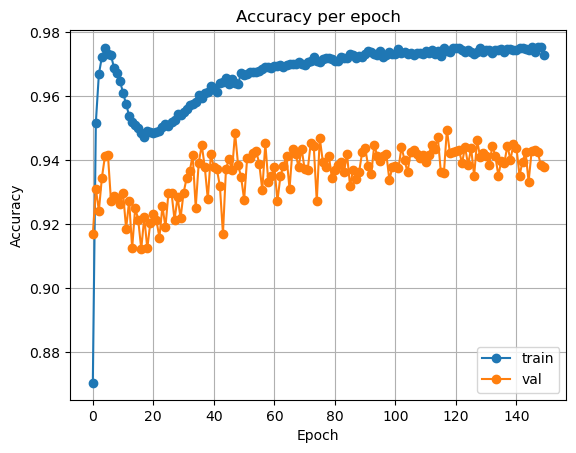

In [64]:
plot_acc(history)

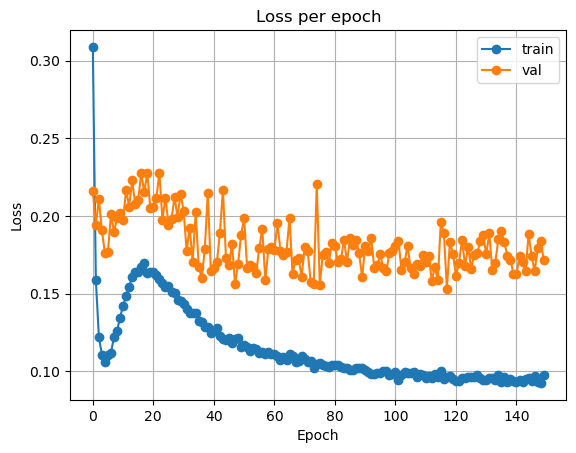

In [65]:
plot_loss(history)

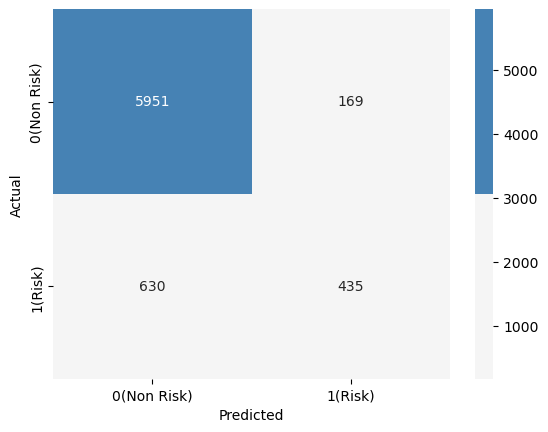

Accuracy: 0.8887961029923451
Recall: 0.4084507042253521
Precision: 0.7201986754966887
F1: 0.5212702216896345


In [74]:
resnet.load_state_dict(torch.load('ResNet_Best.pth'))

# threshold = 0.5
preds = torch.sigmoid(resnet(torch.tensor(X_test.values, dtype=torch.float))) >= torch.FloatTensor([0.5])
preds = np.where(preds.numpy(), 1, 0)

conf_matrix(y_test, preds)

In [77]:
# model save
torch.save(resnet, 'ResNet')